## Titanic

In [200]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')

In [201]:
os.getcwd()
os.chdir('d:\\OneDrive - zju.edu.cn\\Documents\\Git\\Machine-learning\\Machine learning kaggle')

In [202]:
train_df = pd.read_csv('datasets/titanic/train.csv')
test_df = pd.read_csv('datasets/titanic/test.csv')
combine_df = pd.concat([train_df,test_df])
print('combined df:',combine_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB
combined df: None


In [203]:
#Title
combine_df['Title'] = combine_df['Name'].apply(lambda x: x.split(', ')[1]).apply(lambda x: x.split('.')[0])
combine_df['Title'] = combine_df['Title'].replace(['Don','Dona', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col','Sir','Dr'],'Mr')
combine_df['Title'] = combine_df['Title'].replace(['Mlle','Ms'], 'Miss')
combine_df['Title'] = combine_df['Title'].replace(['the Countess','Mme','Lady','Dr'], 'Mrs')
df = pd.get_dummies(combine_df['Title'],prefix='Title')
combine_df = pd.concat([combine_df,df],axis=1)

#Name_length
combine_df['Name_Len'] = combine_df['Name'].apply(lambda x: len(x))
combine_df['Name_Len'] = pd.qcut(combine_df['Name_Len'],20)


#Dead_female_family & Survive_male_family
combine_df['Surname'] = combine_df['Name'].apply(lambda x:x.split(',')[0])
dead_female_surname = list(set(combine_df[(combine_df.Sex=='female') & (combine_df.Age>=12)
                              & (combine_df.Survived==0) & ((combine_df.Parch>0) | (combine_df.SibSp > 0))]['Surname'].values))
# survive_male_surname = list(set(combine_df[(combine_df.Sex=='male') & (combine_df.Age>=12)
#                               & (combine_df.Survived==1) & ((combine_df.Parch>0) | (combine_df.SibSp > 0))]['Surname'].values))
combine_df['Dead_female_family'] = np.where(combine_df['Surname'].isin(dead_female_surname),0,1)
# combine_df['Survive_male_family'] = np.where(combine_df['Surname'].isin(survive_male_surname),0,1)
combine_df = combine_df.drop(['Name','Surname'],axis=1)
# combine_df = combine_df.drop(['Name'],axis=1)



#Age & isChild
# combine_df['Age_null'] = np.where(combine_df['Age'].isnull(),1,0)
group = combine_df.groupby(['Title', 'Pclass'])['Age']
combine_df['Age'] = group.transform(lambda x: x.fillna(x.median()))
combine_df = combine_df.drop('Title',axis=1)
combine_df['IsChild'] = np.where(combine_df['Age']<=12,1,0)
combine_df['IsOld'] = np.where(combine_df['Age']>=60,1,0)
combine_df['Age'] = pd.cut(combine_df['Age'],5)
# combine_df = combine_df.drop('Age',axis=1)

#ticket
combine_df['Ticket_Lett'] = combine_df['Ticket'].apply(lambda x: str(x)[0])
combine_df['Ticket_Lett'] = combine_df['Ticket_Lett'].apply(lambda x: str(x))

combine_df['High_Survival_Ticket'] = np.where(combine_df['Ticket_Lett'].isin(['1', '2', 'P']),1,0)
combine_df['Low_Survival_Ticket'] = np.where(combine_df['Ticket_Lett'].isin(['A','W','3','7']),1,0)
# combine_df = combine_df.drop(['Ticket','Ticket_Lett'],axis=1)

#Embarked
#combine_df = combine_df.drop('Embarked',axis=1)
combine_df.Embarked = combine_df.Embarked.fillna('S')
df = pd.get_dummies(combine_df['Embarked'],prefix='Embarked')
combine_df = pd.concat([combine_df,df],axis=1).drop('Embarked',axis=1)

#FamilySize
combine_df['FamilySize'] = np.where(combine_df['SibSp']+combine_df['Parch']==0, 'Alone',
                                    np.where(combine_df['SibSp']+combine_df['Parch']<=3, 'Small', 'Big'))
df = pd.get_dummies(combine_df['FamilySize'],prefix='FamilySize')
combine_df = pd.concat([combine_df,df],axis=1).drop(['SibSp','Parch','FamilySize'],axis=1)


#Cabin
# combine_df['Cabin_isNull'] = np.where(combine_df['Cabin'].isnull(),0,1)
combine_df = combine_df.drop('Cabin',axis=1)

#PClass
df = pd.get_dummies(combine_df['Pclass'],prefix='Pclass')
combine_df = pd.concat([combine_df,df],axis=1).drop('Pclass',axis=1)


#Sex
df = pd.get_dummies(combine_df['Sex'],prefix='Sex')
combine_df = pd.concat([combine_df,df],axis=1).drop('Sex',axis=1)

#Fare
combine_df['Fare'].fillna(combine_df['Fare'].dropna().median(),inplace=True)
combine_df['Low_Fare'] = np.where(combine_df['Fare']<=8.662,1,0)
combine_df['High_Fare'] = np.where(combine_df['Fare']>=26,1,0)
combine_df = combine_df.drop('Fare',axis=1)

In [204]:
combine_df.columns

Index(['PassengerId', 'Survived', 'Age', 'Ticket', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Name_Len', 'Dead_female_family',
       'IsChild', 'IsOld', 'Ticket_Lett', 'High_Survival_Ticket',
       'Low_Survival_Ticket', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'FamilySize_Alone', 'FamilySize_Big', 'FamilySize_Small', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male', 'Low_Fare',
       'High_Fare'],
      dtype='object')

In [205]:
features = combine_df.drop(["PassengerId","Survived"], axis=1).columns
le = LabelEncoder()
for feature in features:
    le = le.fit(combine_df[feature])
    combine_df[feature] = le.transform(combine_df[feature])

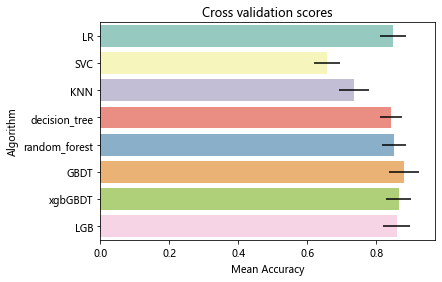

In [206]:
X_all = combine_df.iloc[:891,:].drop(["PassengerId","Survived"], axis=1)
Y_all = combine_df.iloc[:891,:]["Survived"]
X_test = combine_df.iloc[891:,:].drop(["PassengerId","Survived"], axis=1)

logreg = LogisticRegression()
svc = SVC(kernel='rbf')
knn = KNeighborsClassifier(n_neighbors = 5)
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier(n_estimators=300,min_samples_leaf=4,class_weight={0:0.745,1:0.255})
gbdt = GradientBoostingClassifier(n_estimators=500,learning_rate=0.03,max_depth=3)
xgb = XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.03)
lgb = LGBMClassifier(max_depth=3, n_estimators=500, learning_rate=0.02)
clfs = [logreg, svc, knn, decision_tree, random_forest, gbdt, xgb, lgb]

kfold = 10
cv_results = []
for classifier in clfs :
    cv_results.append(cross_val_score(classifier, X_all.values, y = Y_all.values, scoring = "accuracy", cv = kfold, n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

ag = ["LR","SVC",'KNN','decision_tree',"random_forest","GBDT","xgbGBDT", "LGB"]
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,
                       "Algorithm":ag})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [207]:
for i in range(7):
    print(ag[i],cv_means[i])

LR 0.8484769038701623
SVC 0.6577153558052434
KNN 0.7351061173533083
decision_tree 0.8439950062421973
random_forest 0.8507490636704119
GBDT 0.8798751560549313
xgbGBDT 0.8652933832709113


In [208]:
from sklearn.metrics import precision_score

class Bagging(object):
    
    def __init__(self,estimators):
        self.estimator_names = []
        self.estimators = []
        for i in estimators:
            self.estimator_names.append(i[0])
            self.estimators.append(i[1])
        self.clf = LogisticRegression()
    
    def fit(self, train_x, train_y):
        for i in self.estimators:
            i.fit(train_x,train_y)
        x = np.array([i.predict(train_x) for i in self.estimators]).T
        y = train_y
        self.clf.fit(x, y)
    
    def predict(self,x):
        x = np.array([i.predict(x) for i in self.estimators]).T
        #print(x)
        return self.clf.predict(x)
        
    
    def score(self,x,y):
        s = precision_score(y,self.predict(x))
        #print(s)
        return s

In [209]:
lr = LogisticRegression()
decision_tree = DecisionTreeClassifier()
rf = RandomForestClassifier(n_estimators=300,min_samples_leaf=4,class_weight={0:0.745,1:0.255})
gbdt = GradientBoostingClassifier(n_estimators=500,learning_rate=0.03,max_depth=3)
xgbGBDT = XGBClassifier(max_depth=3, n_estimators=500, learning_rate=0.03)
lgb = LGBMClassifier(max_depth=3, n_estimators=500, learning_rate=0.02)
clfs = [logreg, svc, knn, decision_tree, random_forest, gbdt, xgb]

# bag = Bagging([('gbdt',gbdt)])
bag = Bagging([('lr',lr),('rf',rf),('gbdt',gbdt), ("lgb", lgb)])

from sklearn.metrics import precision_score

In [212]:
score = 0
for i in range(0,50):
    num_test = 0.50
    X_train, X_cv, Y_train, Y_cv = train_test_split(X_all.values, Y_all.values, test_size=num_test)
    bag.fit(X_train, Y_train)
    #Y_test = bag.predict(X_test)
    acc_xgb = round(bag.score(X_cv, Y_cv) * 100, 2)
    score+=acc_xgb
    print(acc_xgb)
score/50


80.86
86.75
76.8
80.81
80.0
84.3
85.31
85.8
83.12
85.03
81.62
82.17
81.5
82.47
79.63
81.25
85.53
81.07
79.75
83.75
83.12
84.71
86.16
86.52
80.0
80.62
84.43
83.02
85.06
77.59
79.17
77.51
81.88
83.54
80.0
86.93
79.41
87.41
83.55
84.0
84.52
80.39
83.82
79.44
85.71
81.99
82.58
81.82
80.59
84.62


82.5526

In [211]:
bag.fit(X_all.values, Y_all.values)
print(bag.score(X_all.values, Y_all.values))
Y_test = bag.predict(X_test.values).astype(int)
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_test
    })
submission.to_csv(r'Kaggle-Titanic/Kaggle_submission.csv', index=False)

0.9329268292682927
